In [1]:
# GoogLeNet

# Inception块
# 4个路径从不同层面抽取信息, 然后在输出通道维合并
# Input (复制4份)
#  1) 1x1 Conv
#  2) 1x1 Conv -> 3x3 Conv, pad 1
#  3) 1x1 Conv -> 5x5 Conv, pad 2
#  4) 3x3 MaxPool pad 1 -> 1x1 Conv
# Concatenation (和输出同高同宽)

# 第一个Inception块
# 输入是192x28x28 (通道数是192)
#  1) 1x1 Conv (通道数压到64)
#  2) 1x1 Conv (通道数压到96), 3x3 Conv (通道数压到128); 这里降低通道数来控制模型复杂度
#  3) 1x1 Conv (通道数压到16), 5x5 Conv (通道数压到32)
#  4) 3x3 MaxPool, 1x1 Conv (通道数压到32)
# 重要的参数留给重要的通道

# Inception块
# 跟单3x3和5x5卷积层比, Inception块有更少的参数和计算复杂度
# Inception 0.16M
# 3x3 Conv 0.44M
# 5x5 Conv 1.22M

In [2]:
# GoogLeNet
# 5段, 9个Inception
# stage 1: 7x7 Conv -> 3x3 MaxPool
# stage 2: 1x1 Conv -> 3x3 Conv -> 3x3 MaxPool
# stage 3: 2xInception -> 3x3 MaxPool
# stage 4: 5xInception -> 3x3 MaxPool
# stage 5: 2xInception -> Global AvgPool
# FC

In [3]:
# 段1&2
# 更小的宽口, 更多的通道
#  - 3x224x224
#  - 7x7 Conv(64), stride 2, pad 3
#  - 3x3 MaxPool, stride 2, pad 1
#  - 1x1 Conv(64)
#  - 3x3 Conv(192), pad 1
#  - 3x3 MaxPool, stride 2, pad 1
#  - 192x28x28

In [4]:
# 段3
# 第一段一样
# 第二段通道数变成480, 通过3x3 MaxPool, stride 2, pad 2
# 得到480x14x14

# 段4&5
# 增加通道数, 最后1024x1x1维特征输出

In [5]:
# Inception有各种后续的变种
# Inception-BN使用了batch normalization
# Inception-V3修改了Inception块, 替换5x5为两个3x3, 5x5为1x7和7x1等
# Inception-V4使用残差连接

In [6]:
# 总结
# Inception块用4个不同超参数的卷积层和池化层的路来抽取不同的信息
#  - 主要优点是模型参数小, 计算复杂度低
# GoogleNet使用了9个Inception块, 是第一个达到上百层的网络

In [12]:
import torch
from torch import nn
from torch.nn import functional as F
from d2l import torch as d2l

class Inception(nn.Module):
    def __init__(self, in_channels, c1, c2, c3, c4, **kwargs): #允许Inception实例化过程中接受并传递额外的参数给nn.Module
        super(Inception, self).__init__(**kwargs) 
        self.p1_1 = nn.Conv2d(in_channels, c1, kernel_size=1)
        self.p2_1 = nn.Conv2d(in_channels, c2[0], kernel_size=1)
        self.p2_2 = nn.Conv2d(c2[0], c2[1], kernel_size=3, padding=1)
        self.p3_1 = nn.Conv2d(in_channels, c3[0], kernel_size=1)
        self.p3_2 = nn.Conv2d(c3[0], c3[1], kernel_size=5, padding=2)
        self.p4_1 = nn.MaxPool2d(kernel_size=3, stride=1, padding=1)
        self.p4_2 = nn.Conv2d(in_channels, c4, kernel_size=1)
            
    def forward(self, x):
        p1 = F.relu(self.p1_1(x))
        p2 = F.relu(self.p2_2(F.relu(self.p2_1(x))))
        p3 = F.relu(self.p3_2(F.relu(self.p3_1(x))))
        p4 = F.relu(self.p4_2(self.p4_1(x)))
        return torch.cat((p1, p2, p3, p4), dim=1) # 批量维度是0, 通道数是1

In [13]:
b1 = nn.Sequential(nn.Conv2d(1, 64, kernel_size=7, stride=2, padding=3),
                   nn.ReLU(), nn.MaxPool2d(kernel_size=3, stride=2,
                                           padding=1))

b2 = nn.Sequential(nn.Conv2d(64, 64, kernel_size=1), nn.ReLU(),
                   nn.Conv2d(64, 192, kernel_size=3, padding=1),
                   nn.MaxPool2d(kernel_size=3, stride=2, padding=1))

b3 = nn.Sequential(Inception(192, 64, (96, 128), (16, 32), 32),
                   Inception(256, 128, (128, 192), (32, 96), 64),
                   nn.MaxPool2d(kernel_size=3, stride=2, padding=1))

b4 = nn.Sequential(Inception(480, 192, (96, 208), (16, 48), 64),
                   Inception(512, 160, (112, 224), (24, 64), 64),
                   Inception(512, 128, (128, 256), (24, 64), 64),
                   Inception(512, 112, (144, 288), (32, 64), 64),
                   Inception(528, 256, (160, 320), (32, 128), 128),
                   nn.MaxPool2d(kernel_size=3, stride=2, padding=1))

b5 = nn.Sequential(Inception(832, 256, (160, 320), (32, 128), 128),
                   Inception(832, 384, (192, 384), (48, 128), 128),
                   nn.AdaptiveAvgPool2d((1, 1)), nn.Flatten())

net = nn.Sequential(b1, b2, b3, b4, b5, nn.Linear(1024, 10))

In [14]:
X = torch.rand(size=(1, 1, 96, 96)) #将高宽降低到96
for layer in net:
    X = layer(X)
    print(layer.__class__.__name__, 'output shape:\t', X.shape)

Sequential output shape:	 torch.Size([1, 64, 24, 24])
Sequential output shape:	 torch.Size([1, 192, 12, 12])
Sequential output shape:	 torch.Size([1, 480, 6, 6])
Sequential output shape:	 torch.Size([1, 832, 3, 3])
Sequential output shape:	 torch.Size([1, 1024])
Linear output shape:	 torch.Size([1, 10])


training on cpu


KeyboardInterrupt: 

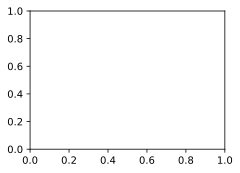

In [15]:
lr, num_epochs, batch_size = 0.1, 10, 128
train_iter, test_iter = d2l.load_data_fashion_mnist(batch_size, resize=96)
d2l.train_ch6(net, train_iter, test_iter, num_epochs, lr, d2l.try_gpu())